In [1]:
import sys, os
sys.path.append("../model/")
sys.path.append("../datasets/")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
from train import getprobs
from EvalTools import *
import numpy as np
import torch
from torch.utils.data import DataLoader
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import json
from scipy import interpolate
from matplotlib import pyplot as plt
from tqdm import tqdm
import gc
#import mpl_scatter_density
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [29]:
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"
dataset = 'jetclass'

#optional parameters to only evaluate certain models
optional_tag = ''
results_dir = 'results/'
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"

result_files = sorted([f for f in os.listdir(results_dir) if dataset in f and optional_tag in f and '.h5' in f])
result_files = [result_files[0]]

In [30]:
group_names = True

if dataset == 'topdata':
    true_classes = [0, 1] # 0:QCD, 1:top
    names = ["background", "signal"]
    groups = ["background", "signal"]
if dataset == 'jetnet':
    true_classes = [0, 1, 2, 3, 4] # 0: g, 1:q, 2:t, 3:w, 4:z
    names = ['light quarks', 'gluons', 'top quarks', 'W bosons', 'Z bosons']
    groups = ['QCD', 'QCD', 'Top', 'Bosons', 'Bosons']
if dataset == 'jetclass':
    true_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # 0: g, 1:q, 2:t, 3:w, 4:z
    names = ['l_QCD', 'l_Hbb', 'l_Hcc', 'l_Hgg', 'l_H4q', 'l_Hqql', 'l_Zqq', 'l_Wqq', 'l_Tbqq', 'l_Tbl']
    groups = ['QCD', 'Higgs', 'Higgs', 'Higgs', 'Higgs', 'Higgs', 'Bosons', 'Bosons', 'Top', 'Top']
if dataset == 'JNqgmerged':
    true_classes = [0, 1, 2, 3] # 0: g/q, 1:t, 2:w, 3:z
    names = ['QCD', 'top quarks', 'W bosons', 'Z bosons']
    groups = ['QCD', 'Top', 'Bosons', 'Bosons']

names = np.array(names)
groups = np.array(groups)
true_names = np.array(names)

if group_names:
    names = groups

uniq_names, ind = np.unique(names, return_index=True)
uniq_names = uniq_names[np.argsort(ind)]

In [31]:
try:
    del model_results
    gc.collect()
except:
    pass
model_results = {}

for modelname in result_files:
    if 'best' in modelname:
        mname = modelname[20:-3]
    else:
        mname = modelname[15:-3]
    print("Getting data")
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")
    if 'best' in modelname:
        model_results[mname] = {'labels' : f['labels'][:], 
                                   'preds': f['preds'][:], 
                                   'maxprobs': f['maxprobs'][:],
                                   'sums':f['sums'][:], 
                                   'oods':f['oods'][:],
                                   'uncs': f['uncs'][:],
                                   'probs': f['probs'][:],
                                   'aug': f['aug'][:],
                                   'latents': f['latents'][:]}
    else:
        model_results[mname] = {'labels' : f['labels'][:], 
                                   'preds': f['preds'][:], 
                                   'maxprobs': f['maxprobs'][:],
                                   'sums':f['sums'][:], 
                                   'oods':f['oods'][:],
                                   'uncs': f['uncs'][:],
                                   'probs': f['probs'][:],
                                   'aug': f['aug'][:]}
    f.close()
    
all_keys = list(model_results.keys())


Getting data


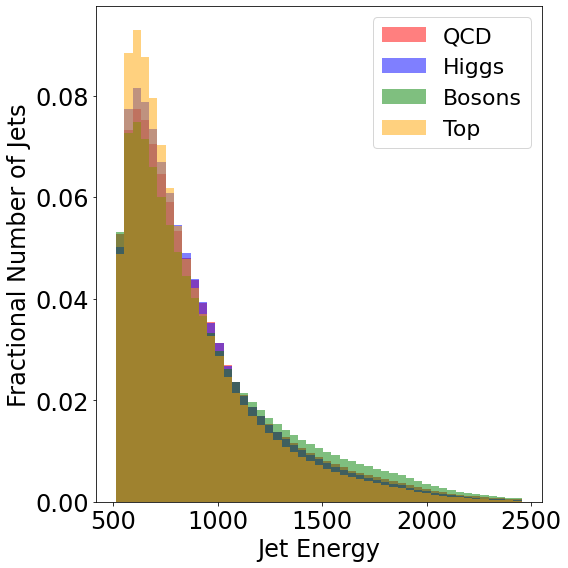

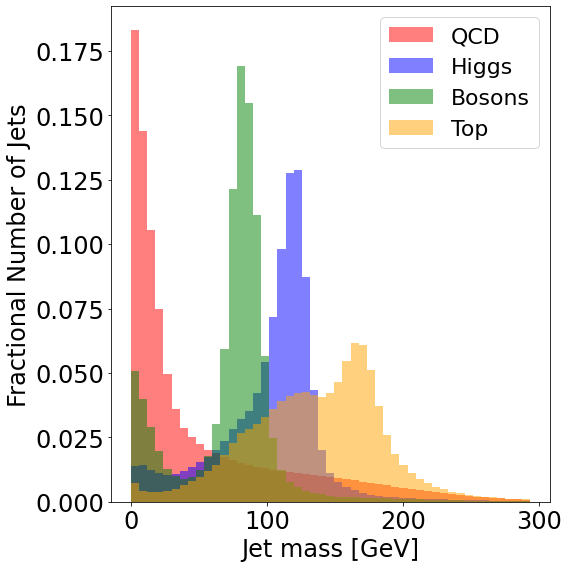

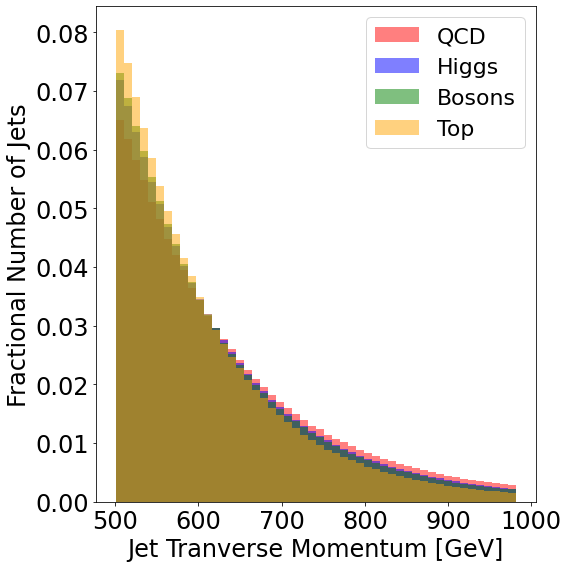

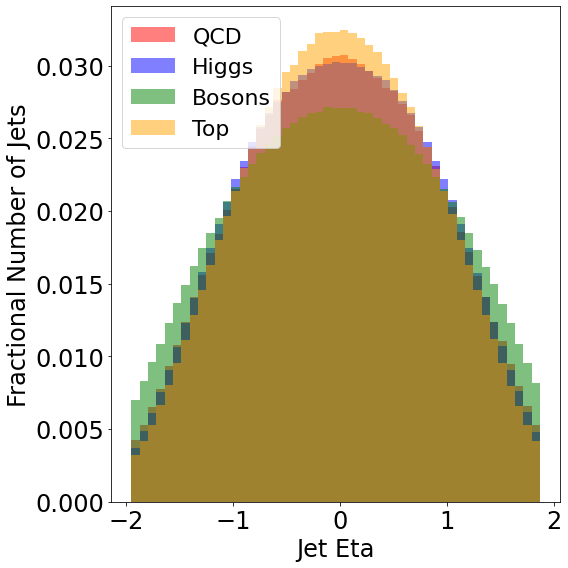

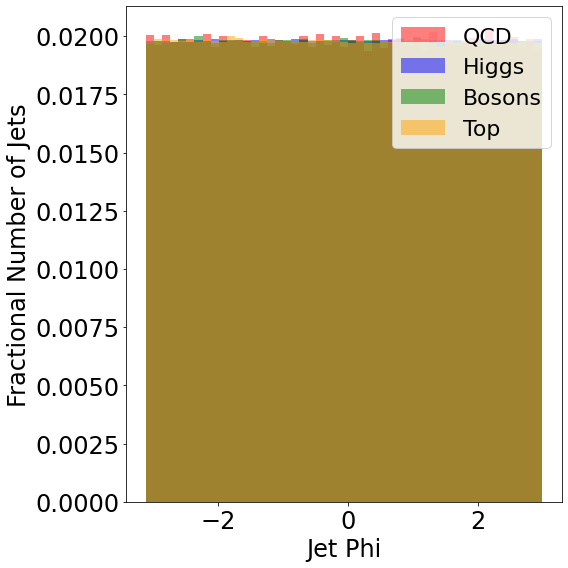

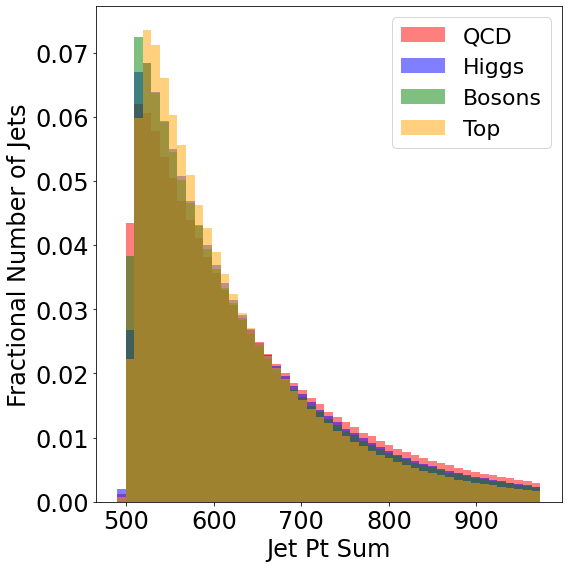

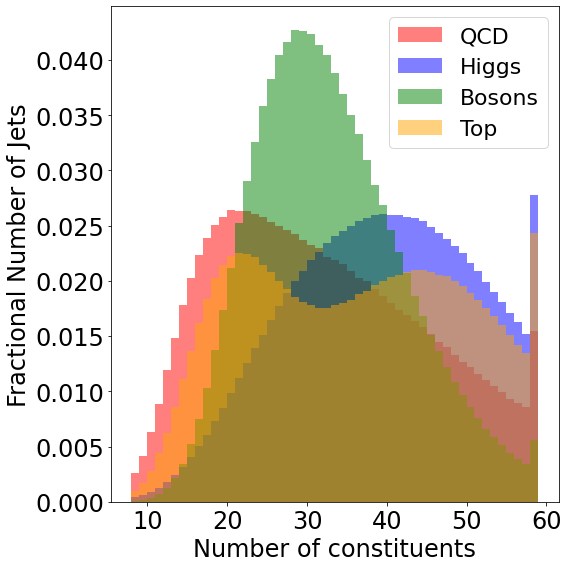

In [32]:
features = ['Jet Energy', 'Jet mass [GeV]', 'Jet Tranverse Momentum [GeV]', 'Jet Eta', 'Jet Phi', 'Jet Pt Sum', 'Number of constituents']
colors=['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'lime', 'cyan', 'gold']
nbins = 50

for ii,key in enumerate(all_keys):
    labels, preds, uncs = model_results[key]['labels'], model_results[key]['preds'], model_results[key]['uncs']
    aug = model_results[key]['aug']
    for jj, f in enumerate(features):
        if jj == 4 and dataset == "jetnet":
            continue
        plt.figure(figsize=(8,8))
        mrs = []
        mls = []
        for i in range(len(names)):
            data = aug[labels == i, jj]
            mrs.append(np.percentile(data, 99.5))
            mls.append(np.percentile(data, 0.5))

        mr = max(mrs)
        ml = min(mls)
        m = mr - ml
        if jj == 6:
            m = nbins
        
        for i in range(len(uniq_names)):
            bkg_data = aug[np.in1d(labels, np.where(names == uniq_names[i])[0]), jj]
            plt.hist(bkg_data, bins=np.arange(ml,mr,m/nbins), label=uniq_names[i], color=colors[i],
                     alpha=0.5, weights = (1./len(bkg_data)) * np.ones_like(bkg_data))
        
        plt.xlabel(f, fontsize=24)
        plt.ylabel("Fractional Number of Jets", fontsize = 24)
        plt.tick_params(axis='both', which='major', labelsize=24)
        plt.legend(fontsize = 22)
        plt.tight_layout()
        plt.savefig("figures/{}_{}.pdf".format(dataset, f))
        plt.show()

In [27]:
jj

4

In [26]:
mr

0.0